this notebook is my attempt at seeing if reverberations will disappear in the spectrograms if I do some edge detection..

In [401]:
from make_training_data import mean_subtract_rowwise
import cv2
import numpy as np
from skimage.filters  import sobel
from skimage import measure
from skimage.morphology import skeletonize, convex_hull_image
from skimage import feature
import scipy.signal as signal 
import scipy.io.wavfile as wav
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000


In [111]:
%matplotlib notebook

In [212]:
fs, audio = wav.read('wavs//'+'ch0_2018-07-28_22-06-13_1532804773.wav')

In [213]:
calc_ind = lambda X : int(X*192000)

In [526]:
start, stop =  2.09, 2.14
start_ind, stop_ind = calc_ind(start), calc_ind(stop)

audio_segment = audio[start_ind:stop_ind]

In [548]:
f, t, S = signal.spectrogram(audio_segment, fs, nperseg=96, noverlap=32)
S = np.flipud(S)
mean_S = mean_subtract_rowwise(S)
if sum(mean_S.flatten()<=0.0) > 0 :
    mean_S += -np.min(mean_S) + 10.0**-5

In [549]:
log_meanS = 20*np.log10(mean_S)
log_S = 20*np.log10(S)

<IPython.core.display.Javascript object>


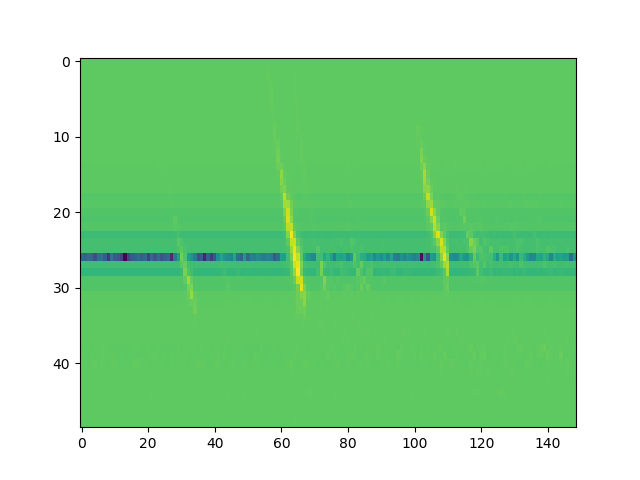

In [550]:
plt.figure()
plt.imshow(log_meanS, aspect='auto')

<IPython.core.display.Javascript object>


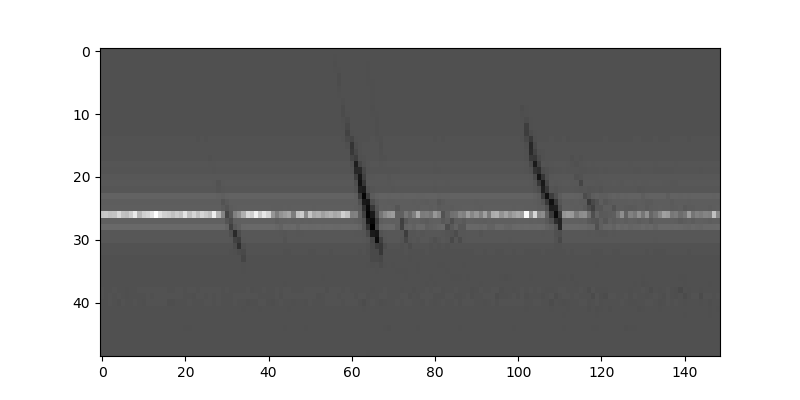

In [551]:
plt.figure(figsize=(8,4))
plt.imshow(log_meanS, aspect='auto', cmap='Greys')

Now, we see some kind of reverberation in the 300th FFt window. I'm going to try and see if doing some edge detection allows me to get rid of this reverberation.

In [552]:
threshold = np.percentile(log_meanS.flatten(),90)
S_sob = np.copy(log_meanS)
S_sob[S_sob<threshold] = -1 
S_sob[S_sob>threshold] = 1 
S_sob = np.uint8(S_sob)

<IPython.core.display.Javascript object>


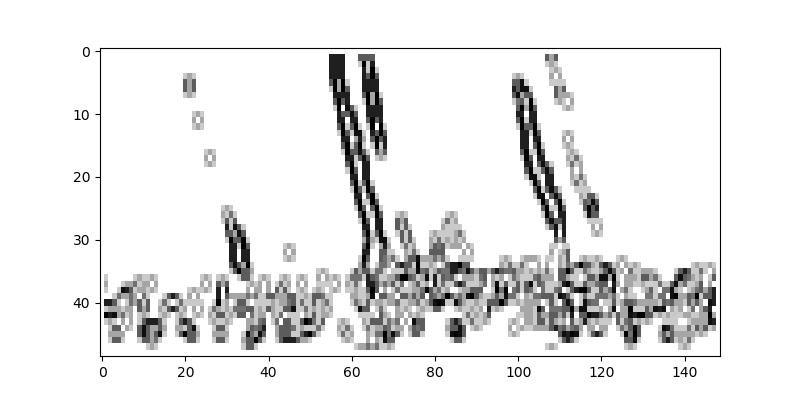

In [553]:
sobel_filtd = sobel(S_sob)
plt.figure(figsize=(8,4))
plt.imshow(sobel_filtd, aspect='auto', cmap='Greys')

Sobel filtering doesn't seem to work too well...

In [554]:
skel_threshold = 99
S_skel = np.copy(S)
S_skel[S_skel< np.percentile(S.flatten(), skel_threshold)] = 0
S_skel[S_skel>= np.percentile(S.flatten(), skel_threshold)] = 1



In [555]:
skeleton = skeletonize(S_skel)

<IPython.core.display.Javascript object>


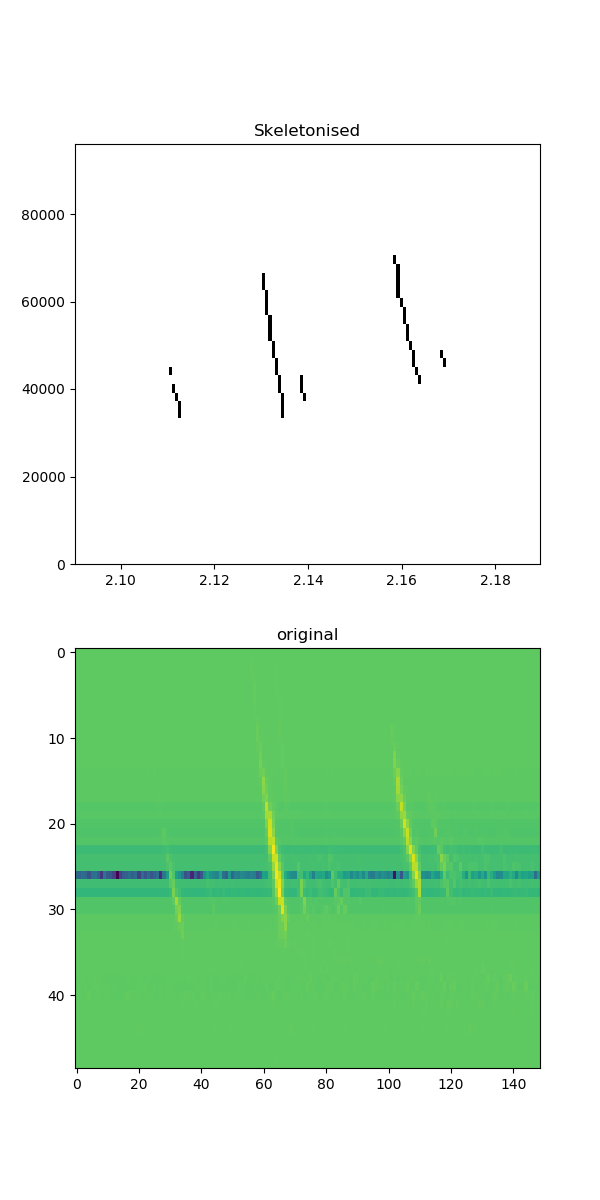

Text(0.5,1,'original')

In [556]:
plt.figure(figsize=(6,12))
plt.subplot(211)
plt.imshow(skeleton, aspect='auto', cmap='Greys', extent=[t[0]+start, t[-1]+stop, f[0], f[-1]])
plt.title('Skeletonised')
plt.subplot(212)
plt.imshow(log_meanS,  aspect='auto')
plt.title('original')

Skeletonisation too -- seems to do an *okay* job...

Let's now try canny edge detection : 

In [557]:
canny_filt = feature.canny(log_meanS, sigma=1)

<IPython.core.display.Javascript object>


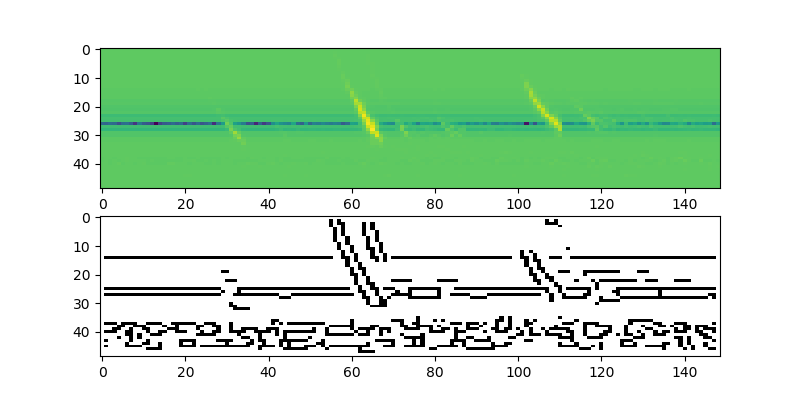

In [558]:

plt.figure(figsize=(8,4))
a = plt.subplot(211)
plt.imshow(log_meanS,  aspect='auto')
plt.subplot(212, sharex=a)
plt.imshow(canny_filt, aspect='auto', cmap='Greys')

Finally, let's try out contour detection as this might help to isolate the bat calls:

In [559]:
# convert the image to 8bit first : 
S_8bit = np.copy(S)
S_8bit *= 1.0/np.max(S)
S_8bit *= 2**8 -1
S_8bit = np.uint8(S_8bit)
# threshold it 
ret,thresh = cv2.threshold(S_8bit,0,255,0)

<IPython.core.display.Javascript object>


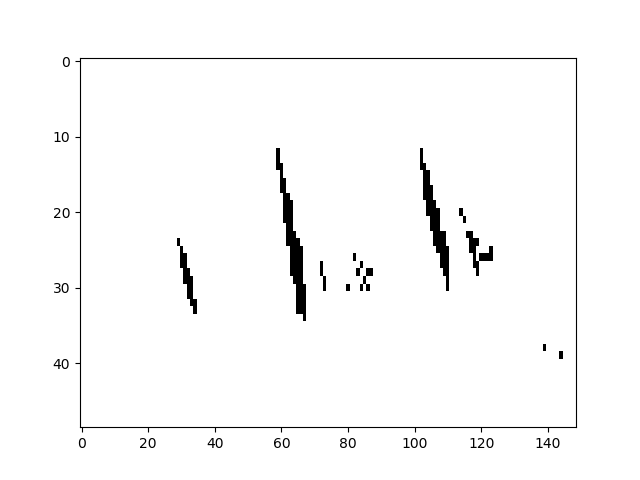

In [560]:
plt.figure()
plt.imshow(thresh, aspect='auto', cmap='Greys')

In [561]:
contours = measure.find_contours(thresh, 1, fully_connected='high')

<IPython.core.display.Javascript object>


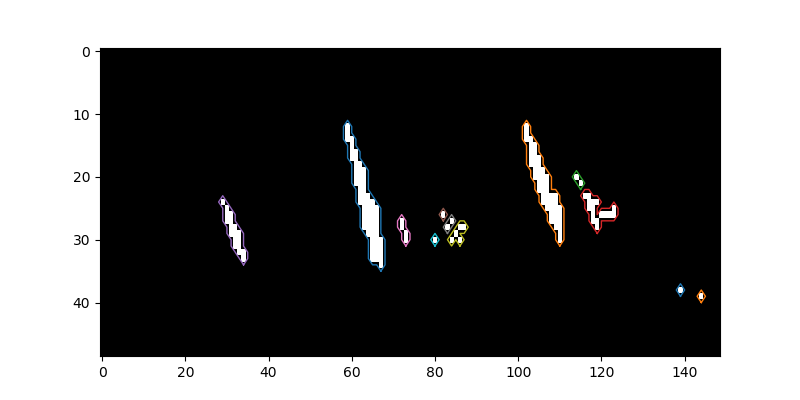

In [562]:
# Display the image and plot all contours found
plt.figure(figsize=(8,4))
plt.imshow(thresh, aspect='auto', interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)
plt.show()

Contour finding works pretty well - though it could get a bit messy when the 

Let's now combine the skeleton with the contours...and see what happens ...:


<IPython.core.display.Javascript object>


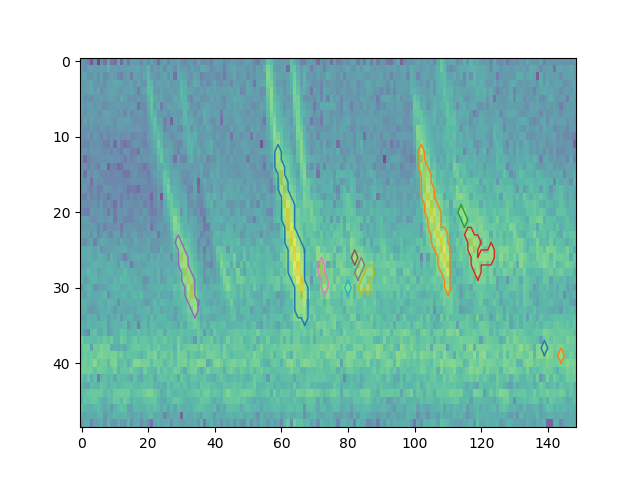

In [568]:
plt.figure()
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)
plt.imshow(log_S, aspect='auto', alpha=0.8)
plt.imshow(skeleton, aspect='auto', alpha=0.1, cmap='Greys')

So, here is the contour of the calls + the skeleton (not so visible, as they're dark yellow inside the contours). The idea is essentially to 
now use the two output methods to reliably extract the bat calls. 